# Creating a custom slice

For instructions how to install and activate ipyparallel for your notebook see 
https://github.com/ipython/ipyparallel

In [1]:
import os

os.environ["IPYTHONDIR"] = ".ipython"
os.environ["IPYTHON_PROFILE"] = "default"

In [2]:
import os

network_path = os.path.join("networks", "slice_example")
mesh_file = os.path.join(network_path, "mesh", "slice.obj")

if not os.path.exists(os.path.dirname(mesh_file)):
    os.makedirs(os.path.dirname(mesh_file))
    

Create a custom slice that is 1000x1000x25 micrometers in size.

In [3]:
from snudda.place import create_slice_mesh
create_slice_mesh(file_name=mesh_file,
                  centre_point=[0.0, 0.0, 0.0],
                  x_len=1e-3,
                  y_len=1e-3,
                  z_len=25e-6,
                  description="This is a test slice corresponding to Allen Institute data")

Creating slice mesh
File: networks/slice_example/mesh/slice.obj
Centre: [0. 0. 0.]
Sides: 0.001 x 0.001 x 2.5e-05
Description: This is a test slice corresponding to Allen Institute data


Here we populate the slice with dSPN and iSPN neurons.

First we ```define_structure```, specifying ```struct_name``` and the ```struct_mesh``` which is a [wavefront obj file](https://en.wikipedia.org/wiki/Wavefront_.obj_file). The ```d_min``` parameter (SI units, so meters) specify how close neurons can be placed. The ```mesh_bin_width``` is voxelisation of the mesh, and it needs to be larger than 2*```d_min```.

Next we ```add_neurons```, passing ```name``` of the neuron, ```volume_id``` it belongs to, and the ```neuron_dir``` where the neurons are located. Note that each dSPN neuron morphology has its own folder, so point to the parent folder e.g. data/neurons/dspn.

The next step is ```add_neuron_target``` which specifies how neurons are coupled together. The connection is from ```neuron_name``` to ```target_name``` of type ```connection_type``` (here GABA). 

The ```dist_pruning``` is optional, and allows us to form preferentially proximal or distal synapses. In this example ```"1-exp(-(0.4*d/60e-6)**2)"``` will result in distal synapses (```d``` is the dendritic distance from the soma). We also specify the pruning parameters ```f1``` (probability of keeping a synapse), ```soft_max``` (a soft upper limit on the number of synapses between connected pairs), ```mu2``` (a soft lower limit on the number of synapses between connected pairs) and ```a3``` (fraction of all connected pairs that we keep, this is useful for changing connection probability without affecting the number of synapses between connected pairs).

The ```conductance``` has two values, the mean and standard deviation. The ```parameter_file``` specifies parameters for the synapse which is moddeled by ```mod_file```. You can also specify additional synapse parameters using the ```channel_param_dictionary```.

Finally we need to write the config file.

In [4]:
from snudda import SnuddaInit

si = SnuddaInit(network_path=network_path, random_seed=123)

n_dspn = 1000
n_ispn = 1000
n_putative_points = (n_dspn + n_ispn)*3

# d_min normally 15e-6, here set to 12e-6 because slice is only 25 micrometers, 2*d_min < mesh_bin_width
si.define_structure(struct_name="SliceExample", struct_mesh=mesh_file, d_min=12e-6, mesh_bin_width=25e-6,
                   n_putative_points=n_putative_points)
si.add_neurons(name="dSPN", num_neurons=n_dspn, volume_id="SliceExample",
                neuron_dir=os.path.join("$DATA","neurons","striatum","dspn"))
si.add_neurons(name="iSPN", num_neurons=n_ispn, volume_id="SliceExample",
                neuron_dir=os.path.join("$DATA","neurons","striatum","ispn"))

SPN2SPNdistDepPruning = "1-exp(-(0.4*d/60e-6)**2)"

MSD1gGABA = [0.24e-9, 0.1e-9]
MSD2gGABA = [0.24e-9, 0.1e-9]

MSD1GABAfailRate = 0.7  # Taverna 2008, figure 2
MSD2GABAfailRate = 0.4  # Taverna 2008, 2mM

pfdSPNdSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-DD-tmgaba-fit.json")
pfdSPNiSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-DI-tmgaba-fit.json")
pfiSPNdSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-ID-tmgaba-fit.json")
pfiSPNiSPN = os.path.join("$DATA", "synapses", "striatum", "PlanertFitting-II-tmgaba-fit.json")

si.add_neuron_target(neuron_name="dSPN",
                     target_name="dSPN",
                     region_name="SliceExample",
                     connection_type="GABA",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=0.38, soft_max=3, mu2=2.4,
                     a3=1.0,
                     conductance=MSD1gGABA,
                     parameter_file=pfdSPNdSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": MSD1GABAfailRate})


si.add_neuron_target(neuron_name="dSPN",
                     target_name="iSPN",
                     region_name="SliceExample",
                     connection_type="GABA",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=0.20, soft_max=3, mu2=2.4,
                     a3=1.0,
                     conductance=MSD1gGABA,
                     parameter_file=pfdSPNiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": MSD1GABAfailRate})


si.add_neuron_target(neuron_name="iSPN",
                     target_name="dSPN",
                     region_name="SliceExample",
                     connection_type="GABA",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=0.3, soft_max=4, mu2=2.4,
                     a3=1.0,
                     conductance=MSD2gGABA,
                     parameter_file=pfiSPNdSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": MSD2GABAfailRate})

si.add_neuron_target(neuron_name="iSPN",
                     target_name="iSPN",
                     region_name="SliceExample",
                     connection_type="GABA",
                     dist_pruning=SPN2SPNdistDepPruning,
                     f1=0.55, soft_max=4, mu2=2.4,
                     a3=1.0,
                     conductance=MSD2gGABA,
                     parameter_file=pfiSPNiSPN,
                     mod_file="tmGabaA",
                     channel_param_dictionary={"tau1": (1.3e-3, 1e3),
                                               "tau2": (12.4e-3, 1e3),
                                               "failRate": MSD2GABAfailRate})

si.write_json()

Adding neurons: dSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/dspn
Adding neurons: iSPN from dir /home/hjorth/HBP/Snudda/snudda/data/neurons/striatum/ispn
Writing networks/slice_example/network-config.json


## Start ipyparallel

In [5]:
os.system("ipcluster start -n 4 --profile=$IPYTHON_PROFILE --ip=127.0.0.1 --log-level ERROR 2> parallel-log.txt &")

import time
time.sleep(10) # Wait for ipcluster to start

## Let Snudda generate the network

In [6]:
from snudda import Snudda
snd = Snudda(network_path=network_path, parallel=True, ipython_profile="default")
snd.create_network()

Placing neurons
Network path: networks/slice_example
Reading IPYPARALLEL connection info from .ipython/profile_default/security/ipcontroller-client.json

Reading SNUDDA_DATA=None from networks/slice_example/network-config.json
Generating 29734 points for networks/slice_example/mesh/slice.obj
n_points = 28287, previous close_pairs = 56325
n_points = 26915, previous close_pairs = 46016
n_points = 25616, previous close_pairs = 38033
n_points = 24388, previous close_pairs = 31644
n_points = 23233, previous close_pairs = 26388
n_points = 22150, previous close_pairs = 22092
n_points = 21140, previous close_pairs = 18461
n_points = 20203, previous close_pairs = 15602
n_points = 19338, previous close_pairs = 13019
n_points = 18550, previous close_pairs = 10734
n_points = 17834, previous close_pairs = 9227
n_points = 17184, previous close_pairs = 7877
n_points = 16600, previous close_pairs = 6655
n_points = 16083, previous close_pairs = 5559
n_points = 15882, previous close_pairs = 4605
n_point

## Stop ipyparallel

In [7]:
os.system("ipcluster stop")

2024-02-23 16:51:46.814 [IPClusterStop] Stopping cluster 
2024-02-23 16:51:46.814 [IPClusterStop] Stopping controller
2024-02-23 16:51:46.911 [IPClusterStop] Stopping engine(s): 1708703443


0

This plots the network, here we leave out axons and dendrites in the figure. Note that matplotlib will distort the axis in 3D plots, causing somas to not appear as spheres.

Reading SNUDDA_DATA=None from networks/slice_example/network-config.json
Reading SNUDDA_DATA=/home/hjorth/HBP/Snudda/snudda/utils/../data from networks/slice_example/network-synapses.hdf5


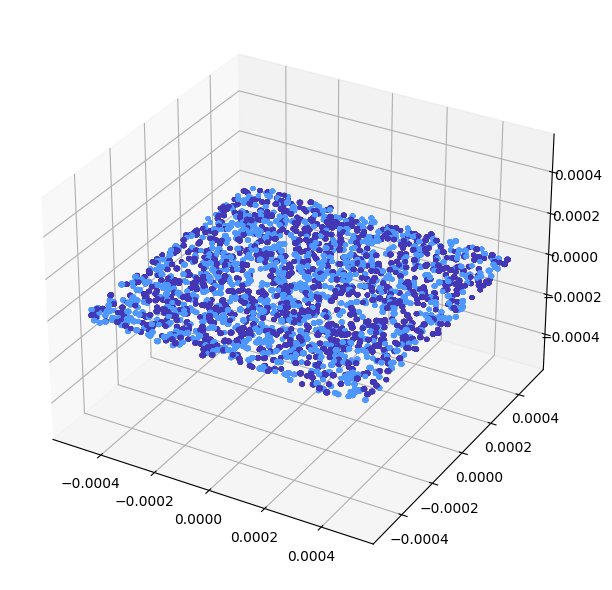

In [8]:
from snudda.plotting import PlotNetwork
network_file = os.path.join(network_path, "network-neuron-positions.hdf5")
pn = PlotNetwork(network_file)
pn.plot(plot_axon=False, plot_dendrite=False, plot_synapses=False)
pn.close() 

For simplicity this notebook is written using serial execution, please see ```simple_network_parallel.ipynb``` for instructions how to make detection and pruning in parallel.

Snudda generates ```examples/notebooks/networks/slice_example/network-neuron-positions.hdf5``` which contains the neuron positions. In the same folder prune creates ```network-synapses.hdf5``` which is the finished network with synapses. To load the data have a look at ```SnuddaLoad``` in ```load.py```.